# Mask Matching, Adjustment, and Repair Pipeline for Bubble Segmentation

This Jupyter Notebook presents a comprehensive pipeline for processing, aligning, and repairing masks associated with bubble segmentation. The primary focus is on ensuring geometric consistency between two sets of binary masks, representing left and right views of bubbles in a very wide-stereo imaging setup (almost opposing). By leveraging feature matching, transformation, and geometric adjustments, this pipeline refines mask alignment and evaluates the quality of adjustments.

---

## Objective

The objective of this notebook is to repair the shapes of **occluded bubbles** captured from two viewpoints (e.g., front and back or left and right). Using synthetic occlusions where parts of the masks have been deliberately cut away, this pipeline aims to:
1. Match corresponding features between the two views of bubbles.
2. Transform and refine the masks for geometric consistency.
3. Reconstruct the missing or occluded parts of the bubble shapes to restore their true boundaries.
4. Evaluate the quality of the repair using Intersection over Union (IoU) metrics and visual comparisons.

---

## Key Features

### 1. **Feature Matching and Transformation**
- **Harris Corner Detection**: Identifies keypoints in the bubble masks to detect feature-rich areas.
- **SIFT Descriptors**: Extracts robust descriptors to enable reliable feature matching across views.
- **Feature Filtering**: Filters matches based on geometric properties like angle and distance for improved accuracy.
- **Affine Transformation Estimation**: Computes transformations to align masks between views, ensuring consistency.

### 2. **Polygon and Radii Representation**
- Represents bubble masks as star-convex polygons using centroid and radii data.
- Smooths radii and computes advanced error metrics to detect regions requiring repair.
- Highlights regions of high error for targeted adjustments.

### 3. **Mask Adjustment**
- Dynamically adjusts radii and polygons in regions of interest (ROI) with high error.
- Applies smooth transition factors to align transformed radii with the original radii, improving mask consistency.

### 4. **Mask Repair**
- Combines adjusted polygons with original masks to reconstruct repaired masks.
- Fills gaps in the bubble boundaries caused by synthetic occlusion.

### 5. **Evaluation**
- **Intersection over Union (IoU)**: Calculates IoU metrics to quantify the accuracy of the repaired masks.
- **Repair-Specific IoU**: Focuses on evaluating the regions of masks affected by the occlusions.
- Visualizes original, repaired, and subtracted masks to directly compare and assess the repair quality.

---

## Code Structure

The notebook is organized into the following sections:

### **Cell 1: Feature Matching**
Loads left and right bubble masks, detects keypoints, applies SIFT for feature matching, and estimates transformations. Visualizes matched features and clustering results for geometric analysis.

### **Cell 2: Transformation and Extended Masks**
Applies transformations to generate extended masks. Computes centroids of masks and visualizes the transformation results alongside bubble boundaries.

### **Cell 3: Star-Convex Polygon Construction**
Constructs polygons for masks using radii sampled at uniform angles around the centroid. Identifies and highlights regions of high squared error for further adjustment.

### **Cell 4: Radii Adjustment**
Dynamically adjusts radii in regions of interest based on transformation data. Visualizes and compares original and adjusted radii to ensure proper alignment.

### **Cell 5: Mask Repair**
Reconstructs bubble shapes by repairing occluded regions using adjusted polygons. Combines original and adjusted masks to produce repaired masks, evaluated with IoU metrics.

### **Cell 6: Repair-Specific IoU**
Focuses IoU calculations on the repaired regions of the masks. Visualizes subtracted masks to highlight areas of improvement.

---

## Applications

This pipeline is specifically designed for **repairing occluded bubble shapes** and can be applied to:
- **Stereo Bubble Imaging**: Aligning and repairing bubble masks captured from left and right views in wide-stereo setups.
- **Bubble Analysis**: Ensuring accurate representations of bubble shapes for size, boundary, and location analysis.
- **Boundary Reconstruction**: Filling gaps in bubble boundaries caused by occlusions or segmentation errors.

---

## Outputs

- **Visualizations**: Plots of original, transformed, and repaired masks, along with radii adjustments and error metrics.
- **Metrics**: IoU values for overall and repaired regions to quantify mask improvements.
- **Repaired Masks**: Final repaired masks ready for analysis or further segmentation.

---

This pipeline provides a robust framework for repairing occluded bubble shapes in segmented masks. By leveraging transformations and geometric adjustments, the notebook ensures high accuracy and consistency across multiple views. Each section is modular and extendable, making it ideal for various bubble-related research and applications.

> **Note:** The images used in this code simulate occlusion by deliberately cutting away parts of the masks. This allows controlled testing of the pipeline's ability to repair missing regions.


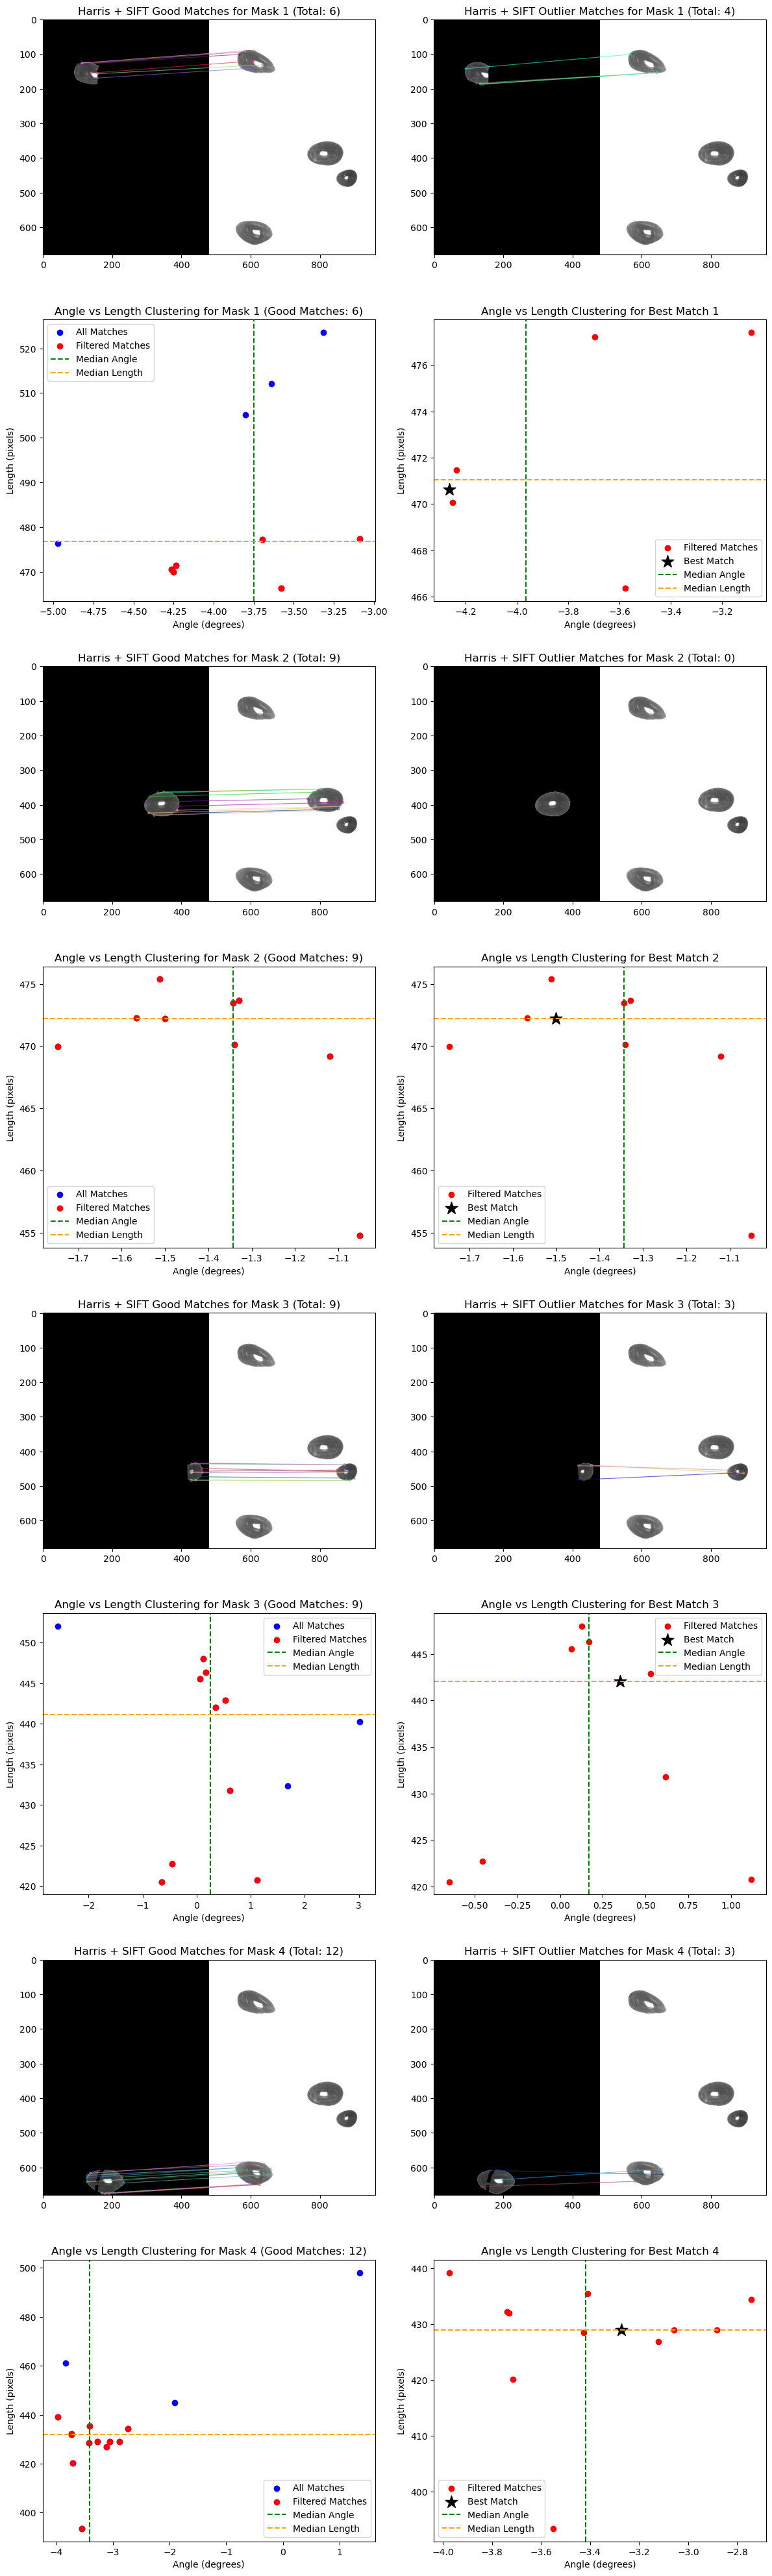

[((113.2131118774414, 126.75409698486328),
  (102.52631378173828, 91.75438690185547)),
 ((308.25, 377.8214416503906), (300.32257080078125, 365.45159912109375)),
 ((429.2257995605469, 435.5806579589844),
  (391.26190185546875, 438.30157470703125)),
 ((170.51063537597656, 674.5531616210938),
  (118.2448959350586, 648.948974609375))]

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Load Images and Bitmap Masks
img_left = cv2.imread('test_links.png', cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread('test_rechts.png', cv2.IMREAD_GRAYSCALE)

# Get list of mask files
left_mask_dir = 'test_links'
right_mask_dir = 'test_rechts'
left_masks_files = sorted([f for f in os.listdir(left_mask_dir) if f.endswith('.png')])
right_masks_files = sorted([f for f in os.listdir(right_mask_dir) if f.endswith('.png')])
img_size = (img_left.shape[1], img_left.shape[0])

# Load masks into memory
left_masks = [cv2.imread(os.path.join(left_mask_dir, mask_file), cv2.IMREAD_GRAYSCALE) for mask_file in left_masks_files]
right_masks = [cv2.imread(os.path.join(right_mask_dir, mask_file), cv2.IMREAD_GRAYSCALE) for mask_file in right_masks_files]

# Apply masks directly to the images
def apply_mask(image, mask):
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    return masked_image

left_masked_images = [apply_mask(img_left, mask) for mask in left_masks]
right_masked_images = [apply_mask(img_right, mask) for mask in right_masks]

# Flip the right images horizontally
img_right_flipped = cv2.flip(img_right, 1)
right_masks_flipped = [cv2.flip(mask, 1) for mask in right_masks]
right_masked_images_flipped = [cv2.flip(image, 1) for image in right_masked_images]

# Harris Corner Detection with increased sensitivity
def detect_harris_corners(image):
    dst = cv2.cornerHarris(image, 2, 3, 0.04)
    dst = cv2.dilate(dst, None)
    ret, dst = cv2.threshold(dst, 0.01 * dst.max(), 255, 0)
    dst = np.uint8(dst)
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    keypoints = [cv2.KeyPoint(pt[0], pt[1], 1) for pt in centroids]
    return keypoints

# Use SIFT to compute descriptors
sift = cv2.SIFT_create()

def compute_sift_descriptors(image, keypoints):
    keypoints, descriptors = sift.compute(image, keypoints)
    return keypoints, descriptors

# Match features and filter outliers
bf_sift = cv2.BFMatcher(cv2.NORM_L2)



def find_best_match(filtered_matches, angles, lengths, median_angle, median_length, keypoints1, keypoints2, mask1, mask2):
    def create_dilated_contour_mask(mask, dilation_size=3):
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour_mask = np.zeros_like(mask, dtype=np.uint8)
        cv2.drawContours(contour_mask, contours, -1, (255), thickness=1)  # thickness=1 to draw only the contour line
        kernel = np.ones((dilation_size, dilation_size), np.uint8)
        dilated_contour_mask = cv2.dilate(contour_mask, kernel, iterations=1)
        return dilated_contour_mask > 0 

    dilated_mask1 = create_dilated_contour_mask(mask1)
    dilated_mask2 = create_dilated_contour_mask(mask2)

    valid_indices = []
    for i, match in enumerate(filtered_matches):
        pt1 = tuple(int(round(x)) for x in keypoints1[match.queryIdx].pt)
        pt2 = tuple(int(round(x)) for x in keypoints2[match.trainIdx].pt)

        if dilated_mask1[pt1[1], pt1[0]] and dilated_mask2[pt2[1], pt2[0]]:
            valid_indices.append(i)

    distances_to_median = [
        np.sqrt((angles[i] - median_angle) ** 2 + (lengths[i] - median_length) ** 2)
        for i in valid_indices]

    if distances_to_median:
        best_valid_index = valid_indices[np.argmin(distances_to_median)]
        return filtered_matches[best_valid_index]
    else:
        return None  # Return None if no valid matches are found


def filter_matches_by_angle_and_length(matches, keypoints1, keypoints2, angle_threshold=1, length_threshold=10):
    angles = []
    lengths = []
    filtered_matches = []
    outlier_matches = []

    for match in matches:
        pt1 = keypoints1[match.queryIdx].pt
        pt2 = keypoints2[match.trainIdx].pt
        adjusted_pt2_x = pt2[0] + img_size[0]
        angle = np.arctan2(pt2[1] - pt1[1], adjusted_pt2_x - pt1[0]) * 180 / np.pi
        length = np.sqrt((adjusted_pt2_x - pt1[0]) ** 2 + (pt2[1] - pt1[1]) ** 2)
        angles.append(angle)
        lengths.append(length)

    median_angle = np.median(angles)
    median_length = np.median(lengths)

    for i, match in enumerate(matches):
        if (abs(angles[i] - median_angle) < angle_threshold) and ((lengths[i] - median_length) < length_threshold):
            filtered_matches.append(match)
        else:
            outlier_matches.append(match)

    return filtered_matches, outlier_matches, angles, lengths, median_angle, median_length

# Store results in a list
matching_results = []
best_matching_pairs = []

num_masks = max(len(left_masked_images), len(right_masked_images_flipped))
fig, axes = plt.subplots(2 * num_masks, 2, figsize=(12, 10 * num_masks))  # Adjusting the height as well

# Ensure axes is always a 2D array, even if num_masks is 1
if num_masks == 1:
    axes = axes.reshape(2, -1) 

def filter_keypoints_by_mask(keypoints, mask, dilation_size=3):

    # Dilate the mask
    kernel = np.ones((dilation_size, dilation_size), np.uint8)
    dilated_mask = cv2.dilate(mask, kernel, iterations=1)
    
    filtered_keypoints = []
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        if 0 <= y < dilated_mask.shape[0] and 0 <= x < dilated_mask.shape[1]:  # Check if within image bounds
            if dilated_mask[y, x] > 0:  # Check if the keypoint lies within the dilated mask
                filtered_keypoints.append(kp)
    return filtered_keypoints

for i in range(num_masks):
    if i < len(left_masked_images) and i < len(right_masked_images_flipped):
        # Harris Keypoints Detection
        left_keypoints_harris = detect_harris_corners(left_masked_images[i])
        right_keypoints_harris = detect_harris_corners(right_masked_images_flipped[i])
        
        # Filter Harris keypoints to ensure they lie inside the mask
        left_keypoints_harris = filter_keypoints_by_mask(left_keypoints_harris, left_masks[i])
        right_keypoints_harris = filter_keypoints_by_mask(right_keypoints_harris, right_masks_flipped[i])
        
        # SIFT Descriptors
        left_keypoints_harris, left_descriptors_harris = compute_sift_descriptors(left_masked_images[i], left_keypoints_harris)
        right_keypoints_harris, right_descriptors_harris = compute_sift_descriptors(right_masked_images_flipped[i], right_keypoints_harris)
        
        # Filter keypoints after SIFT (SIFT may refine keypoints slightly)
        left_keypoints_harris = filter_keypoints_by_mask(left_keypoints_harris, left_masks[i])
        right_keypoints_harris = filter_keypoints_by_mask(right_keypoints_harris, right_masks_flipped[i])
        
        # Recompute SIFT descriptors for filtered keypoints
        left_keypoints_harris, left_descriptors_harris = sift.compute(left_masked_images[i], left_keypoints_harris)
        right_keypoints_harris, right_descriptors_harris = sift.compute(right_masked_images_flipped[i], right_keypoints_harris)
        
        # Apply the ratio test
        matches_harris = bf_sift.knnMatch(left_descriptors_harris, right_descriptors_harris, k=2)
        good_matches = []
        for m, n in matches_harris:
            if m.distance < 0.85 * n.distance:
                good_matches.append(m)
        
        # Filter out matches by angle and length
        filtered_matches, outlier_matches, angles, lengths, median_angle, median_length = filter_matches_by_angle_and_length(good_matches, left_keypoints_harris, right_keypoints_harris)

        # Draw matches on the flipped-back image
        matching_img_harris = cv2.drawMatches(left_masked_images[i], left_keypoints_harris, img_right_flipped, right_keypoints_harris, filtered_matches[:1500], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        outlier_img_harris = cv2.drawMatches(left_masked_images[i], left_keypoints_harris, img_right_flipped, right_keypoints_harris, outlier_matches[:1500], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        axes[2*i, 0].imshow(matching_img_harris, cmap='gray')
        axes[2*i, 0].set_title(f'Harris + SIFT Good Matches for Mask {i+1} (Total: {len(filtered_matches)})')
        
        axes[2*i, 1].imshow(outlier_img_harris, cmap='gray')
        axes[2*i, 1].set_title(f'Harris + SIFT Outlier Matches for Mask {i+1} (Total: {len(outlier_matches)})')

        # Plot the clustering of angles and lengths
        axes[2*i + 1, 0].scatter(angles, lengths, c='blue', label='All Matches')
        filtered_angles = [angles[idx] for idx in range(len(angles)) if good_matches[idx] in filtered_matches]
        filtered_lengths = [lengths[idx] for idx in range(len(lengths)) if good_matches[idx] in filtered_matches]
        axes[2*i + 1, 0].scatter(filtered_angles, filtered_lengths, c='red', label='Filtered Matches')
        axes[2*i + 1, 0].axvline(x=median_angle, color='green', linestyle='--', label='Median Angle')
        axes[2*i + 1, 0].axhline(y=median_length, color='orange', linestyle='--', label='Median Length')
        axes[2*i + 1, 0].set_title(f'Angle vs Length Clustering for Mask {i+1} (Good Matches: {len(filtered_matches)})')
        axes[2*i + 1, 0].set_xlabel('Angle (degrees)')
        axes[2*i + 1, 0].set_ylabel('Length (pixels)')
        axes[2*i + 1, 0].legend()
        
        # Compute new Medians       
        median_angle = np.median(filtered_angles)
        median_length = np.median(filtered_lengths)
        
        # Find the best match with consideration for edge proximity
        best_match = find_best_match(filtered_matches, angles, lengths, median_angle, median_length, left_keypoints_harris, right_keypoints_harris, left_masks[i], right_masks_flipped[i])
        best_matching_pairs.append((left_keypoints_harris[best_match.queryIdx].pt, right_keypoints_harris[best_match.trainIdx].pt))
            
        # Store the matching results for later use
        matching_results.append({
            'left_keypoints_harris': left_keypoints_harris,
            'right_keypoints_harris': right_keypoints_harris,
            'filtered_matches': filtered_matches,
            'median_angle': median_angle,
            'median_length': median_length,
            'best_match': best_match
        })
        
        # Plot filtered matches and the best match
        axes[2*i + 1, 1].scatter(filtered_angles, filtered_lengths, c='red', label='Filtered Matches')
        best_angle = angles[filtered_matches.index(best_match)]
        best_length = lengths[filtered_matches.index(best_match)]
        axes[2*i + 1, 1].scatter([best_angle], [best_length], c='black', marker='*', s=200, label='Best Match')
        axes[2*i + 1, 1].axvline(x=median_angle, color='green', linestyle='--', label='Median Angle')
        axes[2*i + 1, 1].axhline(y=median_length, color='orange', linestyle='--', label='Median Length')
        axes[2*i + 1, 1].set_title(f'Angle vs Length Clustering for Best Match {i+1}')
        axes[2*i + 1, 1].set_xlabel('Angle (degrees)')
        axes[2*i + 1, 1].set_ylabel('Length (pixels)')
        axes[2*i + 1, 1].legend()

    
    else:
        for j in range(2):  # Update to handle 2 columns
            axes[2*i, j].axis('off')
            axes[2*i + 1, j].axis('off')

plt.tight_layout()
plt.savefig('harris_sift_matching_and_clustering_results_with_best_match.png')
plt.show()

# Save the best matching pairs
best_matching_pairs



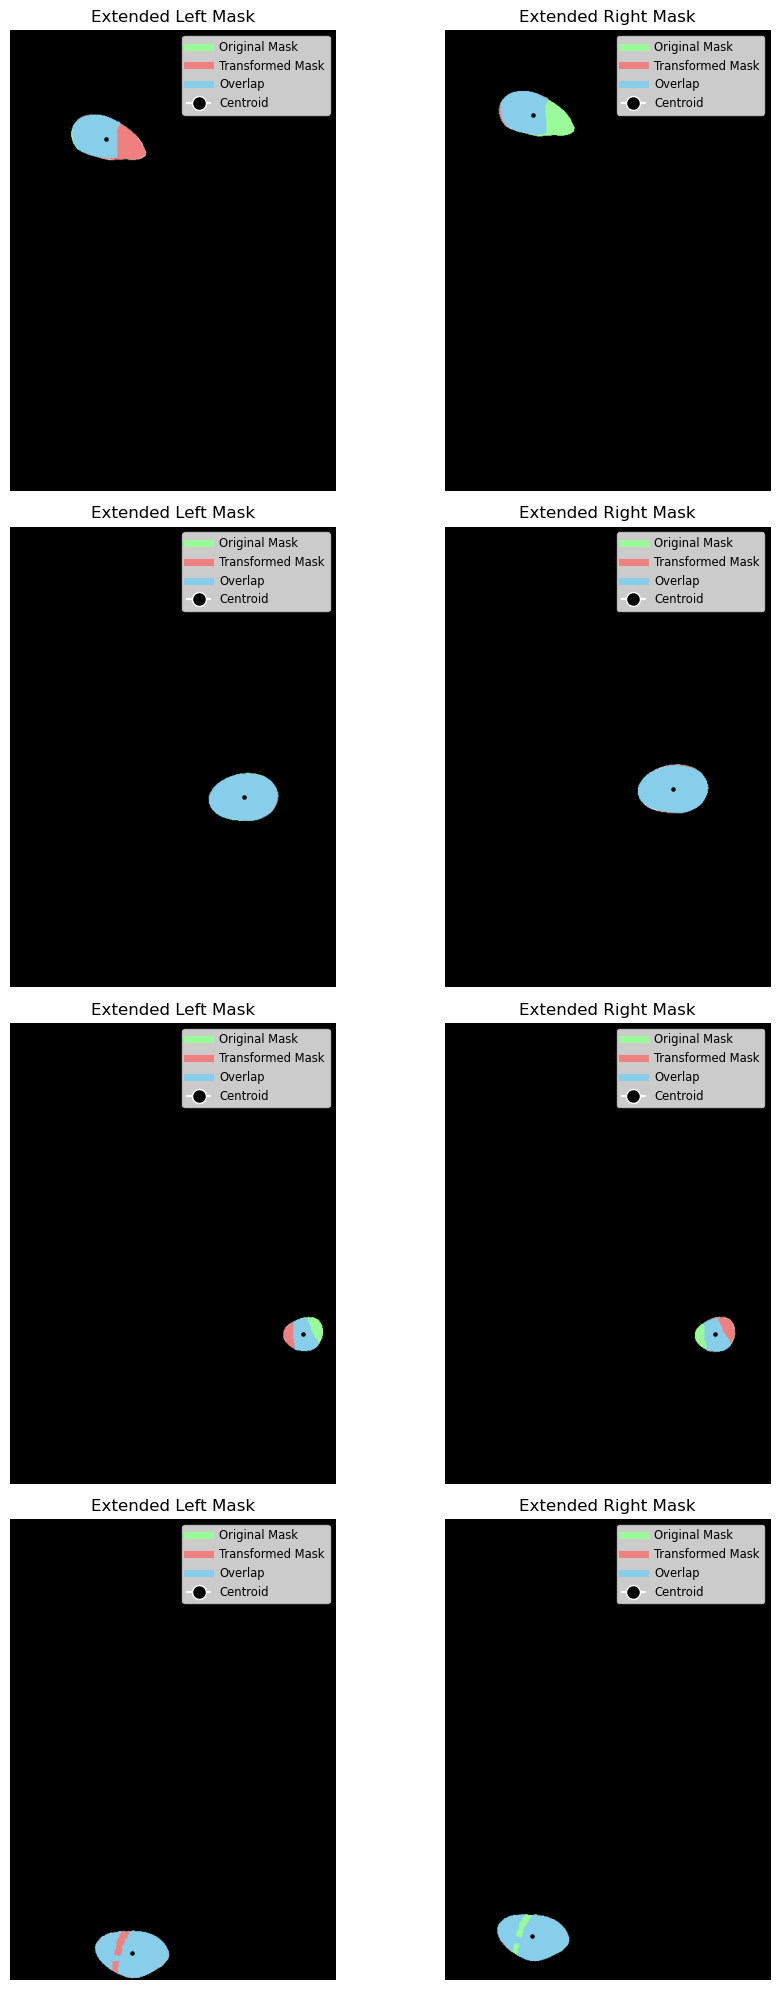

[[-129.88883943224485, -130.43143362363062], [-149.35719307170342, -148.86892557075086], [-97.05400150422717, -108.88390833681588], [103.42959172402689, 107.57830739153508]]

[[(141, 160)], [(344, 399)], [(432, 458)], [(179, 639)]]

[[(130, 124)], [(336, 387)], [(398, 458)], [(129, 615)]]


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# RGB colors
base_color = [152, 251, 152]
warped_color = [240, 128, 128]
overlap_color = [135, 206, 235]

# Function to calculate transformation matrices
def get_transformation_matrix(keypoints1, keypoints2, matches):
    if len(matches) == 0:
        return None
    try:
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    except IndexError as e:
        print(f"IndexError: {e}")
        print(f"Keypoints1 length: {len(keypoints1)}, Keypoints2 length: {len(keypoints2)}")
        print(f"Matches: {matches}")
        return None
    
    # Calculate the affine transformation matrix
    M, mask = cv2.estimateAffinePartial2D(src_pts, dst_pts)
    return M

# Function to apply the transformation and create the extended mask
def apply_transformation_and_create_extended_mask(base_image, transform_image, M):
    rows, cols = base_image.shape
    
    # Warp the transform_image using the transformation matrix
    warped_image = cv2.warpAffine(transform_image, M, (cols, rows))

    # Combine the base_image and the warped_image by taking the maximum value at each pixel location
    combined_mask = np.maximum(base_image, warped_image)
    
    # Create a colored version of the base image and the warped image
    base_colored = cv2.cvtColor(base_image, cv2.COLOR_GRAY2RGB)
    base_colored[np.where((base_colored == [255, 255, 255]).all(axis=2))] = base_color  # Light sky blue for base mask
    
    warped_colored = cv2.cvtColor(warped_image, cv2.COLOR_GRAY2RGB)
    warped_colored[np.where((warped_colored == [255, 255, 255]).all(axis=2))] = warped_color  # Coral red for transformed mask
    
    # Combine the images
    combined_in_colors = cv2.addWeighted(base_colored, 1, warped_colored, 1, 0)
    
    # Highlight overlapping regions
    overlap = np.logical_and(base_image > 0, warped_image > 0)
    combined_in_colors[overlap] = overlap_color  # Medium purple for overlap

    return warped_image, combined_mask, combined_in_colors 

# Function to augment a 2x3 matrix to a 3x3 matrix and invert it
def invert_affine_transform(M):
    M_augmented = np.vstack([M, [0, 0, 1]])
    M_inverse_augmented = np.linalg.inv(M_augmented)
    return M_inverse_augmented[:2, :]

# Apply transformations and create extended masks
extended_left_masks = []
extended_right_masks = []
extended_left_masks_colored = []
extended_right_masks_colored = []
left_transformed_to_right = []
right_transformed_to_left = []

for i, result in enumerate(matching_results):
    left_keypoints_harris = result['left_keypoints_harris']
    right_keypoints_harris = result['right_keypoints_harris']
    filtered_matches = result['filtered_matches']

    # Calculate the transformation matrix for each mask pair
    M_left_to_right = get_transformation_matrix(left_keypoints_harris, right_keypoints_harris, filtered_matches)
    if M_left_to_right is None:
        print(f"Skipping mask {i+1} due to failed transformation matrix calculation.")
        continue

    # Compute the inverse of the transformation matrix
    M_right_to_left = invert_affine_transform(M_left_to_right)

    
    # Create the extended masks for each pair independently
    right_warped_to_left, extended_left_mask, extended_left_mask_colored = apply_transformation_and_create_extended_mask(left_masks[i], right_masks_flipped[i], M_right_to_left)
    left_warped_to_right, extended_right_mask, extended_right_mask_colored, = apply_transformation_and_create_extended_mask(right_masks_flipped[i], left_masks[i], M_left_to_right)
    
    extended_left_masks.append(extended_left_mask)
    extended_right_masks.append(extended_right_mask)
    extended_left_masks_colored.append(extended_left_mask_colored)
    extended_right_masks_colored.append(extended_right_mask_colored)
    left_transformed_to_right.append(left_warped_to_right)
    right_transformed_to_left.append(right_warped_to_left)


# Function to compute centroids of masks
def compute_centroids(mask):
    centroids = []
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        M = cv2.moments(cnt)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            centroids.append((cx, cy))
    return centroids

# Compute centroids for each mask
left_centroids = [compute_centroids(mask) for mask in extended_left_masks]
right_centroids = [compute_centroids(mask) for mask in extended_right_masks]

# Function to calculate the angle between two points
def calculate_angle(p1, p2):
    angle = np.arctan2(p2[1] - p1[1], p2[0] - p1[0]) * 180 / np.pi
    return angle

# Compute angles between best matching pairs and centroids
angles_list = []

# Plot the results with centroids and best matching pairs
fig, axes = plt.subplots(len(extended_left_masks_colored), 2, figsize=(10, 5 * len(extended_left_masks_colored)))

for i in range(len(extended_left_masks_colored)):
    left_centroid = left_centroids[i][0] if left_centroids[i] else None
    right_centroid = right_centroids[i][0] if right_centroids[i] else None
    
    left_best_match = best_matching_pairs[i][0]
    right_best_match = best_matching_pairs[i][1]
    
    left_angle = None
    right_angle = None

    if left_centroid and left_best_match:
        left_angle = calculate_angle(left_centroid, left_best_match)
        
    if right_centroid and right_best_match:
        right_angle = calculate_angle(right_centroid, right_best_match)
    
    angles_list.append([left_angle, right_angle])
    
    axes[i, 0].imshow(extended_left_masks_colored[i])
    axes[i, 0].set_title(f'Extended Left Mask')
    axes[i, 0].axis('off')
    if left_centroid:
        axes[i, 0].scatter(*left_centroid, color='black', s=5)  # Mark centroids with black dots
    #if left_best_match:
    #    axes[i, 0].scatter(*left_best_match, color='red', marker='*', s=75)  # Mark best match with red star
    #if left_centroid and left_best_match:
    #    axes[i, 0].plot([left_centroid[0], left_best_match[0]], [left_centroid[1], left_best_match[1]], color='red', linewidth=1, linestyle='--')

    axes[i, 1].imshow(extended_right_masks_colored[i])
    axes[i, 1].set_title(f'Extended Right Mask')
    axes[i, 1].axis('off')
    #if right_centroid and right_best_match:
    #    axes[i, 1].plot([right_centroid[0], right_best_match[0]], [right_centroid[1], right_best_match[1]], color='red', linewidth=1, linestyle='--')
    if right_centroid:
         axes[i, 1].scatter(*right_centroid, color='black', s=5)  # Mark centroids with black dots
    #if right_best_match:
    #    axes[i, 1].scatter(*right_best_match, color='red', marker='*', s=75)  # Mark best match with red star

    # Normalize the colors for matplotlib in the legend
    base_color_norm = [x / 255 for x in base_color]
    warped_color_norm = [x / 255 for x in warped_color]
    overlap_color_norm = [x / 255 for x in overlap_color]
    
    handles = [
        plt.Line2D([0], [0], color=base_color_norm, lw=5, label='Original Mask'),
        plt.Line2D([0], [0], color=warped_color_norm, lw=5, label='Transformed Mask'),
        plt.Line2D([0], [0], color=overlap_color_norm, lw=5, label='Overlap'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Centroid'),
        #plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='red', markersize=10, label='Best Match')
    ]
    
    axes[i, 0].legend(handles=handles, loc='upper right', fontsize='small')
    axes[i, 1].legend(handles=handles, loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()

# Print the angles list
print (angles_list)
print ("")
print (left_centroids)
print ("")
print (right_centroids)

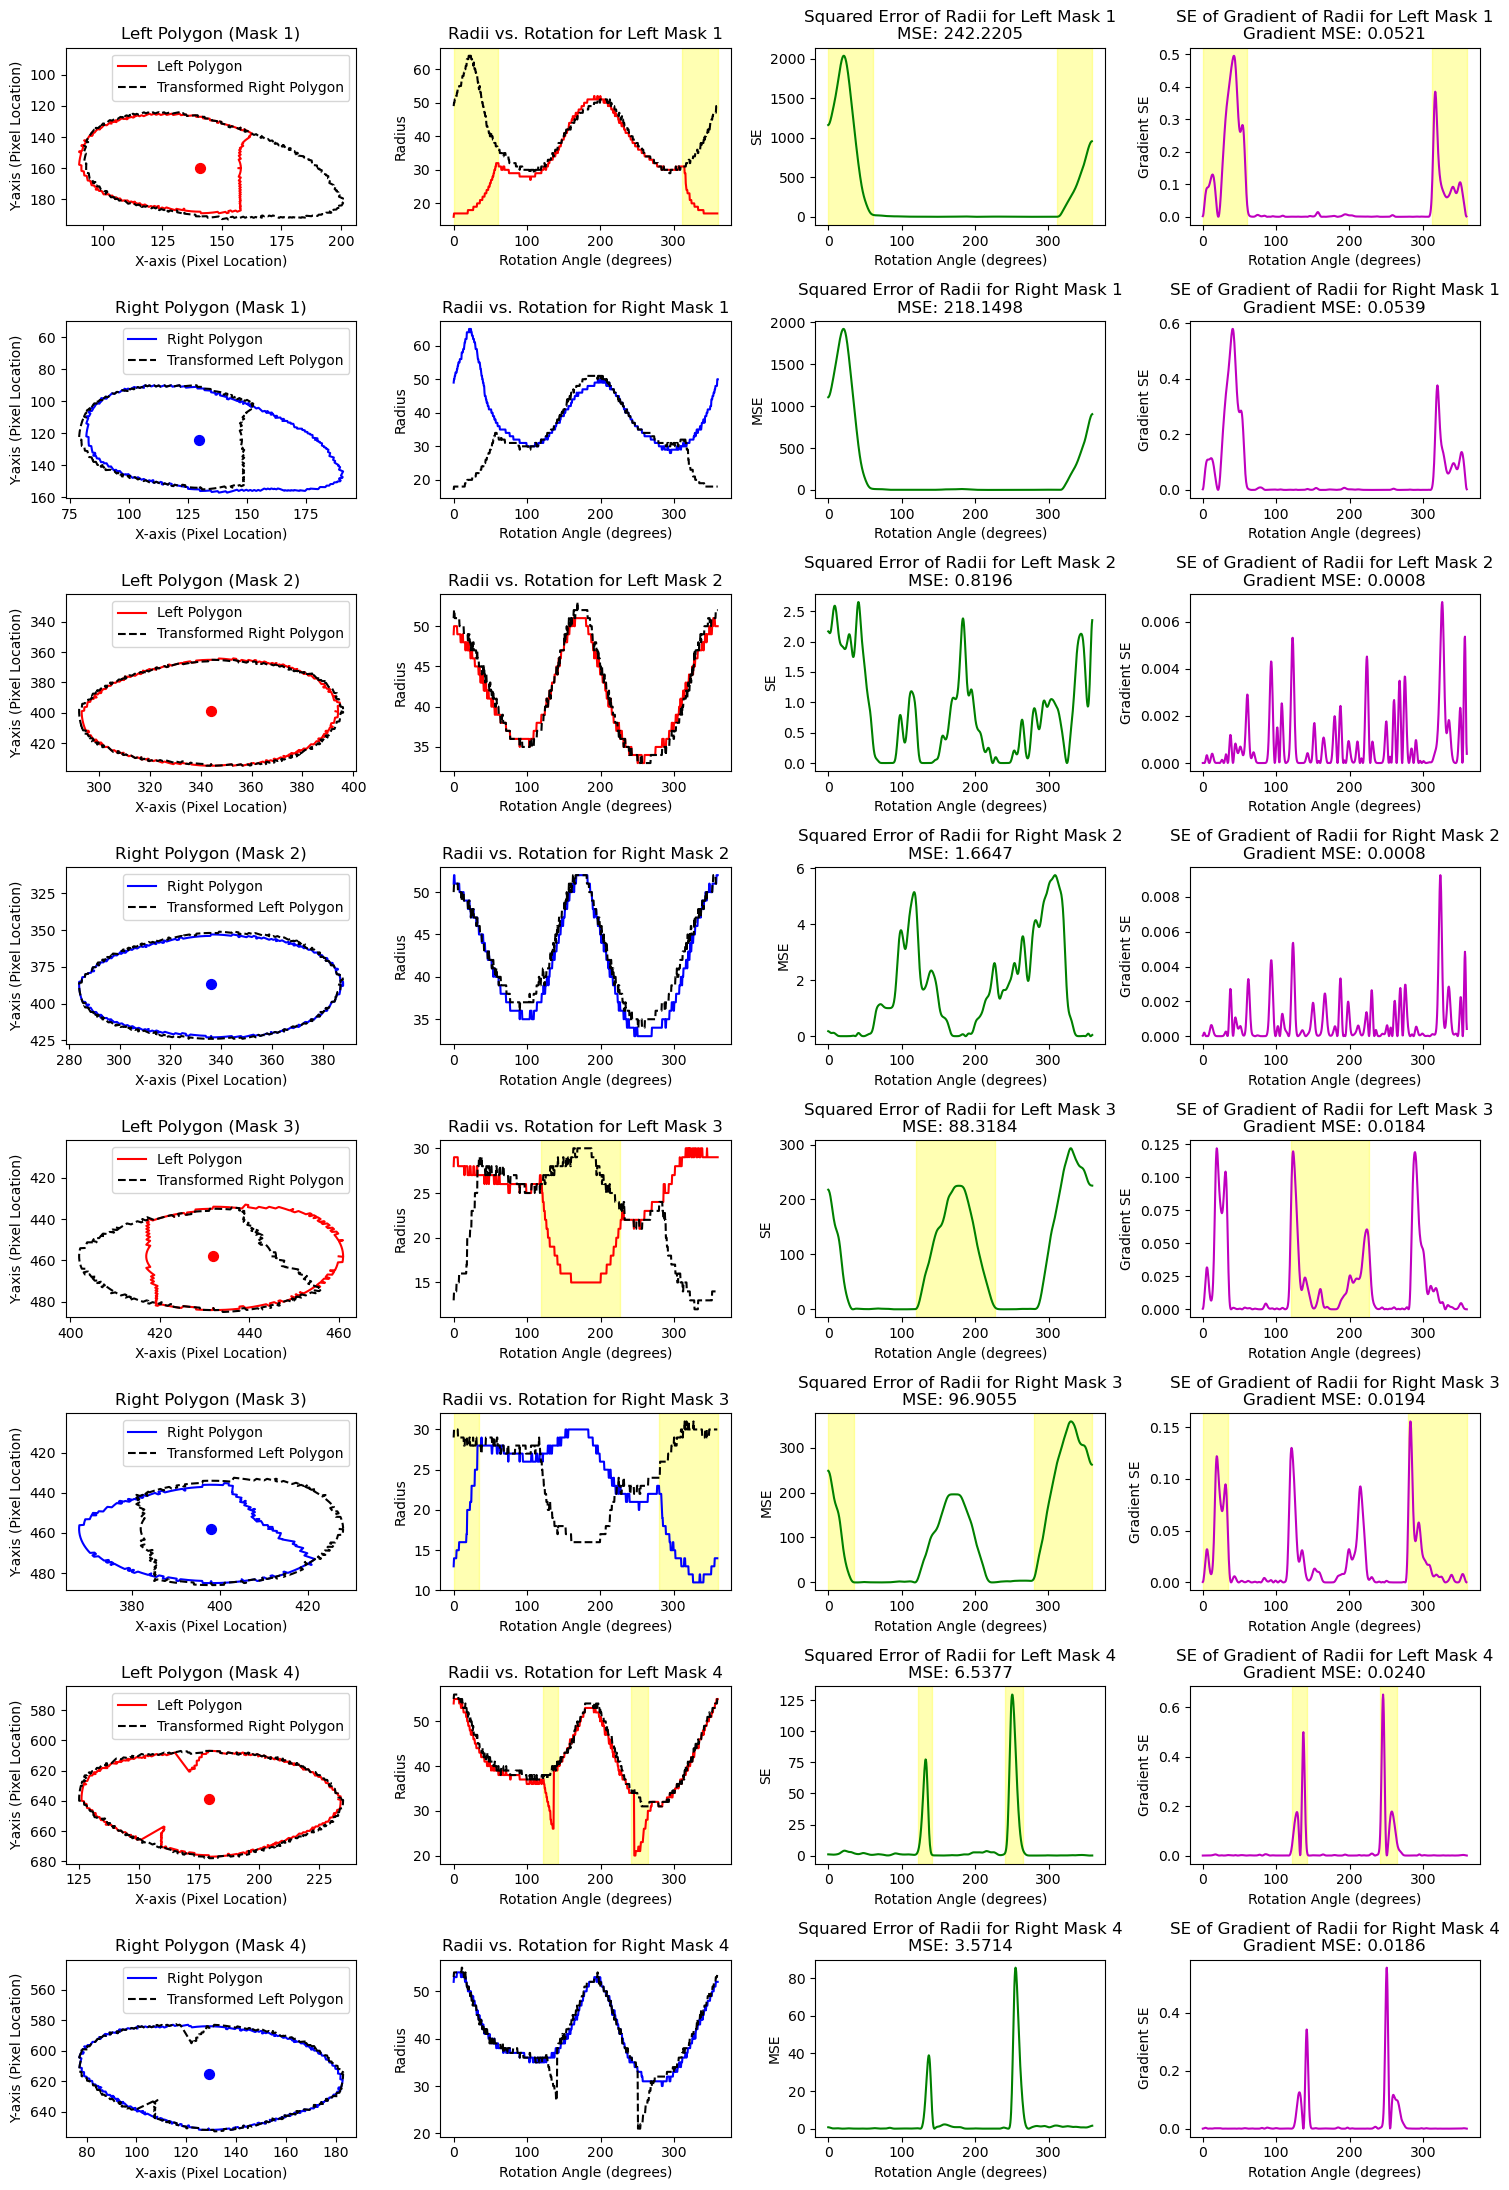

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

number_of_points = 360*2

# Function to create a star-convex polygon given a centroid and a list of radii
def create_star_convex_polygon(centroid, angles, radii):
    points = []
    for angle, radius in zip(angles, radii):
        x = centroid[0] + radius * np.cos(np.deg2rad(angle))
        y = centroid[1] + radius * np.sin(np.deg2rad(angle))
        points.append((x, y))
    points = np.array(points)
    
    # Sort points by angle (to ensure they form a valid polygon when plotted)
    sorted_indices = np.argsort(angles)
    points = points[sorted_indices]
    
    return points

# Function to calculate the radii from a centroid to the farthest white edge before hitting black
def calculate_radii(centroid, mask, angles):
    radii = []
    for angle in angles:
        x = centroid[0]
        y = centroid[1]
        max_radius = 0
        while (0 <= x < mask.shape[1]) and (0 <= y < mask.shape[0]):
            if mask[int(y), int(x)] != 0:
                # Continue to update the max_radius if the pixel is white
                current_radius = np.sqrt((x - centroid[0])**2 + (y - centroid[1])**2)
                if current_radius > max_radius:
                    max_radius = current_radius
            x += np.cos(np.deg2rad(angle))
            y += np.sin(np.deg2rad(angle))
        radii.append(max_radius)
    return radii

# Function to resample polygon points to a fixed number of vertices
def resample_polygon(polygon, num_points=number_of_points):
    distances = np.cumsum(np.sqrt(np.sum(np.diff(polygon, axis=0)**2, axis=1)))
    distances = np.insert(distances, 0, 0)
    interpolator = interp1d(distances, polygon, axis=0, kind='linear', fill_value='extrapolate')
    uniform_distances = np.linspace(0, distances[-1], num_points)
    resampled_polygon = interpolator(uniform_distances)
    return resampled_polygon



    
def compute_gradient_squared_errors(original, transformed, sigma=6):
    original = np.array(original)
    transformed = np.array(transformed)
    # Smooth the radii data before computing the gradients
    original_smooth = gaussian_filter1d(original, sigma=sigma)
    transformed_smooth = gaussian_filter1d(transformed, sigma=sigma)
    # Calculate the gradients
    original_grad = np.gradient(original_smooth)
    transformed_grad = np.gradient(transformed_smooth)
    # Compute the squared differences of the gradients
    grad_diff = (original_grad - transformed_grad) ** 2
    return grad_diff, np.mean(grad_diff)



def compute_squared_errors(original, transformed, sigma=6):
    # Convert to numpy arrays for consistency
    original = np.array(original)
    transformed = np.array(transformed)
    
    # Apply Gaussian smoothing
    original_smooth = gaussian_filter1d(original, sigma=sigma)
    transformed_smooth = gaussian_filter1d(transformed, sigma=sigma)
    
    # Compute the squared errors
    squared_errors = (original_smooth - transformed_smooth) ** 2
    mse = np.mean(squared_errors)
    
    return squared_errors, mse

def compute_higher_order_gradient(values, order=2):
    if order == 4:
        # Using a higher-order central difference
        return np.gradient(values, edge_order=2)
    else:
        # Default to first order if not specified otherwise
        return np.gradient(values)


# Function to find regions of high SE and refine using Gradient SE with an additional SE range threshold
def find_regions_of_interest(se, grad_se, original_radii, transformed_radii, se_threshold, grad_se_threshold, new_grad_se_threshold, search_window):
    # Step 1: Identify initial high interest points
    high_se_indices = [
        i for i in range(len(se))
        if se[i] > se_threshold and original_radii[i] < transformed_radii[i]
    ]

    # Group contiguous indices into regions
    regions = []
    if high_se_indices:
        current_region = [high_se_indices[0]]
        for i in range(1, len(high_se_indices)):
            if high_se_indices[i] - high_se_indices[i - 1] <= 1:
                current_region.append(high_se_indices[i])
            else:
                regions.append(current_region)
                current_region = [high_se_indices[i]]
        regions.append(current_region)

    # Step 2: Validate regions with sufficient grad_se
    valid_regions = []
    for region in regions:
        if any(grad_se[i] > grad_se_threshold for i in region):
            valid_regions.append(region)

    # Step 3: Refine regions
    refined_regions = []
    se_mean = np.mean(se)  # Compute the mean squared error once for efficiency
    for region in valid_regions:
        region_start, region_end = region[0], region[-1]

        # Determine the ranges for start and end refinements
        start_candidates = range(max(0, region_start - search_window // 2), min(region_start + search_window // 2, region_end))
        end_candidates = range(max(region_start, region_end - search_window // 2), min(len(grad_se), region_end + search_window // 2))

        # Refine the start of the region
        for i in reversed(list(start_candidates)):
            if grad_se[i+1] > new_grad_se_threshold and np.all(grad_se[i-20:i] < new_grad_se_threshold) and se[i] < se_mean:
                region_start = i
                break

        # Refine the end of the region
        for i in list(end_candidates):
            if grad_se[i-1] > new_grad_se_threshold and np.all(grad_se[i:i + 20] < new_grad_se_threshold) and se[i] < se_mean:
                region_end = i
                break

        # Append refined region if it has a significant length
        if (region_end - region_start + 1) >= 10:
            refined_regions.append((region_start, region_end))
            

    return refined_regions



def merge_boundary_regions(regions, angle_count):
    if not regions:
        return regions

    merged_regions = []
    skip_first = False

    # Check if the first and last regions should be connected
    if regions[-1][-1] == angle_count - 1 and regions[0][0] == 0:
        # Merge them into a single region
        merged_regions.append((regions[-1][0], regions[0][1]))
        skip_first = True
    else:
        merged_regions.append(regions[-1])

    # Add remaining regions
    if not skip_first:
        merged_regions.append(regions[0])
    merged_regions.extend(regions[1:-1])
    
    # Remove duplicates and preserve order
    seen = set()
    unique_regions = []
    for region in merged_regions:
        if region not in seen:
            seen.add(region)
            unique_regions.append(region)

    return unique_regions

# Parameters
se_threshold = 10  # Set an appropriate MSE threshold
grad_se_threshold = 0.05  # Set an appropriate gradient MSE threshold
border_grad_se_threshold = 0.05 # Cross over value to find
search_window = 90  # Number of degrees to search beyond the initial MSE region


# Initialize lists to store regions of interest and transformed polygons
regions_of_interest_left = []
regions_of_interest_right = []
right_transformed_to_left_polygons = []
left_transformed_to_right_polygons = []
left_polygons = []
right_polygons = []

# Lists to store centroids and radii
left_centroids_list = []
right_centroids_list = []
left_radii_list = []
right_radii_list = []
right_transformed_to_left_radii_list = []
left_transformed_to_right_radii_list = []


# Generate a set of angles to sample the radii
angles = np.linspace(0, 360, number_of_points, endpoint=False)

# Generate and plot the polygons
fig, axes = plt.subplots(len(left_centroids) * 2, 4, figsize=(15, 5.5 * len(left_centroids)))



        
for i, (left_centroid, right_centroid, angle_pair) in enumerate(zip(left_centroids, right_centroids, angles_list)):
    if left_centroid and right_centroid:
        left_centroid = left_centroid[0]
        right_centroid = right_centroid[0]

        # Calculate radii
        left_radii = calculate_radii(left_centroid, left_masks[i], angles)
        right_radii = calculate_radii(right_centroid, right_masks_flipped[i], angles)
        
        # Save centroids and radii to the lists
        left_centroids_list.append(left_centroid)
        right_centroids_list.append(right_centroid)
        left_radii_list.append(left_radii)
        right_radii_list.append(right_radii)

        # Create polygons
        left_polygon = create_star_convex_polygon(left_centroid, angles, left_radii)
        right_polygon = create_star_convex_polygon(right_centroid, angles, right_radii)
        
        # Calculate transformed radii
        right_transformed_to_left_radii = calculate_radii(left_centroid, right_transformed_to_left[i], angles)
        left_transformed_to_right_radii = calculate_radii(right_centroid, left_transformed_to_right[i], angles)
        
        # Save transformed radii to the lists
        right_transformed_to_left_radii_list.append(right_transformed_to_left_radii)
        left_transformed_to_right_radii_list.append(left_transformed_to_right_radii)
        
        # Create transformed polygons
        right_transformed_to_left_polygon = create_star_convex_polygon(left_centroid, angles, right_transformed_to_left_radii)
        left_transformed_to_right_polygon = create_star_convex_polygon(right_centroid, angles, left_transformed_to_right_radii)
        
        # Store the transformed polygons
        right_transformed_to_left_polygons.append(right_transformed_to_left_polygon)
        left_transformed_to_right_polygons.append(left_transformed_to_right_polygon)
        
        left_polygons.append(left_polygon)
        right_polygons.append(right_polygon)
     

        # First row (left mask)
        axes[2*i, 0].plot(*zip(*left_polygon), color='red', linestyle='-', label='Left Polygon', linewidth=1.5)
        axes[2*i, 0].plot(*zip(*right_transformed_to_left_polygon), 'k--', label='Transformed Right Polygon', linewidth=1.5)
        #axes[2*i, 0].plot(*zip(*right_polygon), color='grey', linestyle='-', label='Right Polygon (Pre-Transformed)', linewidth=0.5)
        axes[2*i, 0].scatter(*left_centroid, color='red', s=50)
        axes[2*i, 0].set_title(f'Left Polygon (Mask {i+1})')
        axes[2*i, 0].invert_yaxis() # Ensure the y-axis increases upwards
        y_lim = axes[2*i, 0].get_ylim()
        axes[2*i, 0].set_ylim([y_lim[0], y_lim[1]-0.5*(y_lim[0]-y_lim[1])])
        axes[2*i, 0].legend(loc='upper right', frameon=True)
        axes[2*i, 0].set_xlabel('X-axis (Pixel Location)')
        axes[2*i, 0].set_ylabel('Y-axis (Pixel Location)')
        
        axes[2*i, 1].plot(angles, left_radii, 'r-', label='Left Radii')
        axes[2*i, 1].plot(angles, right_transformed_to_left_radii, 'k--', label='Transformed Right Radii', linewidth=1.5)
        axes[2*i, 1].set_title(f'Radii vs. Rotation for Left Mask {i+1}')
        axes[2*i, 1].set_xlabel('Rotation Angle (degrees)')
        axes[2*i, 1].set_ylabel('Radius')

        # Calculate and plot SE of radii
        radii_se_left, radii_mse_left = compute_squared_errors(left_radii, right_transformed_to_left_radii)
        axes[2*i, 2].plot(angles, radii_se_left, 'g-', label='SE Radii')
        axes[2*i, 2].set_title(f'Squared Error of Radii for Left Mask {i+1}\nMSE: {radii_mse_left:.4f}')
        axes[2*i, 2].set_xlabel('Rotation Angle (degrees)')
        axes[2*i, 2].set_ylabel('SE')

        # Calculate and plot Gradient SE of radii
        grad_se_left, grad_mse_left = compute_gradient_squared_errors(left_radii, right_transformed_to_left_radii)
        axes[2*i, 3].plot(angles, grad_se_left, 'm-', label='SE Gradient Radii')
        axes[2*i, 3].set_title(f'SE of Gradient of Radii for Left Mask {i+1}\nGradient MSE: {grad_mse_left:.4f}')
        axes[2*i, 3].set_xlabel('Rotation Angle (degrees)')
        axes[2*i, 3].set_ylabel('Gradient SE')

        # Store regions of interest for left mask
        regions_left = find_regions_of_interest(radii_se_left, grad_se_left, left_radii, right_transformed_to_left_radii, se_threshold, grad_se_threshold, border_grad_se_threshold, search_window) 
        merged_regions_left = merge_boundary_regions(regions_left, len(angles))
        regions_of_interest_left.append(merged_regions_left)


        
        
        # Highlight regions of interest in the plots
        for region_start, region_end in merged_regions_left:
            if region_start <= region_end:
                axes[2*i, 1].axvspan(angles[region_start], angles[region_end], color='yellow', alpha=0.3)  # Radii plot
                axes[2*i, 2].axvspan(angles[region_start], angles[region_end], color='yellow', alpha=0.3)  # MSE plot
                axes[2*i, 3].axvspan(angles[region_start], angles[region_end], color='yellow', alpha=0.3)  # Gradient MSE plot
            else:  # If region wraps around
                axes[2*i, 1].axvspan(angles[region_start], 360, color='yellow', alpha=0.3)  # Wrap around end
                axes[2*i, 1].axvspan(0, angles[region_end], color='yellow', alpha=0.3)  # Wrap around start
                axes[2*i, 2].axvspan(angles[region_start], 360, color='yellow', alpha=0.3)
                axes[2*i, 2].axvspan(0, angles[region_end], color='yellow', alpha=0.3)
                axes[2*i, 3].axvspan(angles[region_start], 360, color='yellow', alpha=0.3)
                axes[2*i, 3].axvspan(0, angles[region_end], color='yellow', alpha=0.3)

        # Second row (right mask)
        axes[2*i+1, 0].plot(*zip(*right_polygon), color='blue', linestyle='-', label='Right Polygon', linewidth=1.5)
        axes[2*i+1, 0].plot(*zip(*left_transformed_to_right_polygon), 'k--', label='Transformed Left Polygon', linewidth=1.5)
        #axes[2*i+1, 0].plot(*zip(*left_polygon), color='grey', linestyle='-', label='Left Polygon (Pre-Transformed)', linewidth=0.5)
        axes[2*i+1, 0].scatter(*right_centroid, color='blue', s=50)
        axes[2*i+1, 0].set_title(f'Right Polygon (Mask {i+1})') 
        axes[2*i+1, 0].invert_yaxis() # Ensure the y-axis increases upwards
        y_lim = axes[2*i+1, 0].get_ylim()
        axes[2*i+1, 0].set_ylim([y_lim[0], y_lim[1]-0.5*(y_lim[0]-y_lim[1])])
        axes[2*i+1, 0].legend(loc='upper right', frameon=True)
        axes[2*i+1, 0].set_xlabel('X-axis (Pixel Location)')
        axes[2*i+1, 0].set_ylabel('Y-axis (Pixel Location)')

        axes[2*i+1, 1].plot(angles, right_radii, 'b-', label='Right Radii')
        axes[2*i+1, 1].plot(angles, left_transformed_to_right_radii, 'k--', label='Transformed Left Radii', linewidth=1.5)
        axes[2*i+1, 1].set_title(f'Radii vs. Rotation for Right Mask {i+1}')
        axes[2*i+1, 1].set_xlabel('Rotation Angle (degrees)')
        axes[2*i+1, 1].set_ylabel('Radius')

        # Calculate and plot SE of radii for right mask
        radii_se_right, radii_mse_right = compute_squared_errors(right_radii, left_transformed_to_right_radii)
        axes[2*i+1, 2].plot(angles, radii_se_right, 'g-', label='SE Radii')
        axes[2*i+1, 2].set_title(f'Squared Error of Radii for Right Mask {i+1}\nMSE: {radii_mse_right:.4f}')
        axes[2*i+1, 2].set_xlabel('Rotation Angle (degrees)')
        axes[2*i+1, 2].set_ylabel('MSE')

        # Calculate and plot Gradient SE of radii for right mask
        grad_se_right, grad_mse_right = compute_gradient_squared_errors(right_radii, left_transformed_to_right_radii)
        axes[2*i+1, 3].plot(angles, grad_se_right, 'm-', label='Squared Error Gradient Radii')
        axes[2*i+1, 3].set_title(f'SE of Gradient of Radii for Right Mask {i+1}\nGradient MSE: {grad_mse_right:.4f}')
        axes[2*i+1, 3].set_xlabel('Rotation Angle (degrees)')
        axes[2*i+1, 3].set_ylabel('Gradient SE')

        # Store regions of interest for right mask
        regions_right = find_regions_of_interest(radii_se_right, grad_se_right, right_radii, left_transformed_to_right_radii, se_threshold, grad_se_threshold, border_grad_se_threshold, search_window)
        merged_regions_right = merge_boundary_regions(regions_right, len(angles))
        regions_of_interest_right.append(merged_regions_right)

        # Highlight regions of interest in the plots
        for region_start, region_end in merged_regions_right:
            if region_start <= region_end:
                axes[2*i+1, 1].axvspan(angles[region_start], angles[region_end], color='yellow', alpha=0.3)  # Radii plot
                axes[2*i+1, 2].axvspan(angles[region_start], angles[region_end], color='yellow', alpha=0.3)  # SE plot
                axes[2*i+1, 3].axvspan(angles[region_start], angles[region_end], color='yellow', alpha=0.3)  # Gradient SE plot
            else:  # If region wraps around
                axes[2*i+1, 1].axvspan(angles[region_start], 360, color='yellow', alpha=0.3)  # Wrap around end
                axes[2*i+1, 1].axvspan(0, angles[region_end], color='yellow', alpha=0.3)  # Wrap around start
                axes[2*i+1, 2].axvspan(angles[region_start], 360, color='yellow', alpha=0.3)
                axes[2*i+1, 2].axvspan(0, angles[region_end], color='yellow', alpha=0.3)
                axes[2*i+1, 3].axvspan(angles[region_start], 360, color='yellow', alpha=0.3)
                axes[2*i+1, 3].axvspan(0, angles[region_end], color='yellow', alpha=0.3)

    else:
        for j in range(4):
            axes[2*i, j].axis('off')
            axes[2*i+1, j].axis('off')

plt.tight_layout()
plt.show()



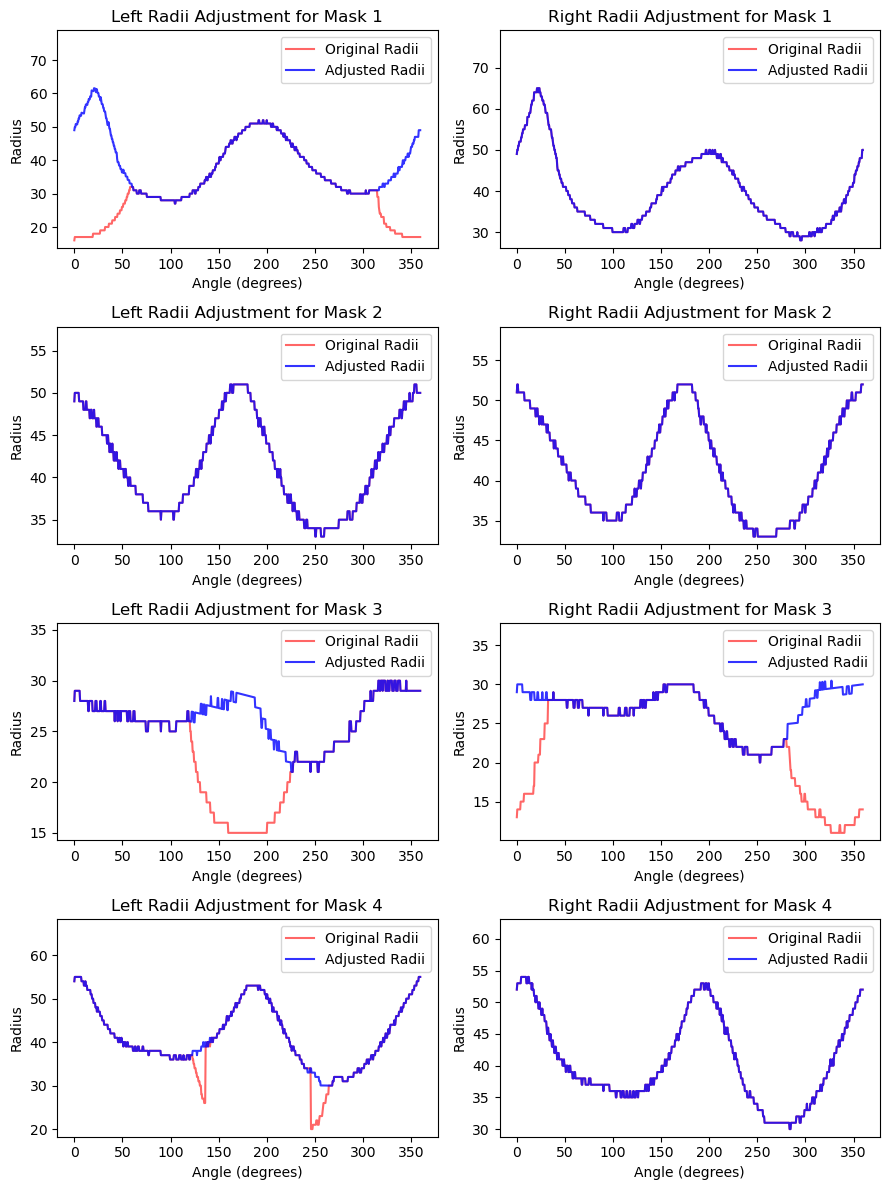

In [4]:

import numpy as np
import matplotlib.pyplot as plt

# Function to compute transition factors for smooth transition
def compute_transition_factors(start_factor, end_factor, num_points):
    """
    Compute a linear transition of factors from start to end for the given number of points.
    
    Parameters:
    start_factor (float): The factor at the start point.
    end_factor (float): The factor at the end point.
    num_points (int): The number of points to compute in the transition.
    
    Returns:
    np.array: An array of transition factors.
    """
    return np.linspace(start_factor, end_factor, num_points)


# Function to compute the border factors from the original and transformed radii
def compute_border_factors(original_radii, transformed_radii, regions_of_interest):
    """
    Compute the factors required to rescale the transformed radii to match the original radii.
    
    Parameters:
    original_radii (list): List of original radii.
    transformed_radii (list): List of transformed radii to use as reference for adjustment.
    regions_of_interest (list): List of tuples with (start_index, end_index) indicating regions to adjust.
    
    Returns:
    list: A list of tuples (start_factor, end_factor) for each region.
    """
    border_factors = []
    for region_start, region_end in regions_of_interest:
        start_factor = original_radii[region_start] / transformed_radii[region_start] if transformed_radii[region_start] != 0 else 1
        end_factor = original_radii[region_end] / transformed_radii[region_end] if transformed_radii[region_end] != 0 else 1
        border_factors.append((start_factor, end_factor))
    
    return border_factors


# Function to apply the computed transition factors to the radii in the region of interest
def apply_transition_factors_to_radii(original_radii, transformed_radii, regions_of_interest):
    """
    Apply the transition factors to the radii for each region of interest.
    
    Parameters:
    original_radii (list): List of original radii.
    transformed_radii (list): List of transformed radii to use as reference for adjustment.
    regions_of_interest (list): List of tuples with (start_index, end_index) indicating regions to adjust.
    
    Returns:
    np.array: The adjusted radii.
    """
    adjusted_radii = original_radii.copy()
    
    # Compute the border factors dynamically from the transformed and original radii
    border_factors = compute_border_factors(original_radii, transformed_radii, regions_of_interest)
    
    for region, (start_factor, end_factor) in zip(regions_of_interest, border_factors):
        region_start, region_end = region
        if region_start <= region_end:
            num_points = region_end - region_start + 1
            transition_factors = compute_transition_factors(start_factor, end_factor, num_points)
            adjusted_radii[region_start:region_end + 1] = transformed_radii[region_start:region_end + 1] * transition_factors
        else:  # Handle wrap-around case
            num_points_1 = len(adjusted_radii) - region_start
            num_points_2 = region_end + 1
            transition_factors_1 = compute_transition_factors(start_factor, 1, num_points_1)  # Start to end of array
            transition_factors_2 = compute_transition_factors(1, end_factor, num_points_2)  # Start of array to end factor
            adjusted_radii[region_start:] = transformed_radii[region_start:] * transition_factors_1
            adjusted_radii[:region_end + 1] = transformed_radii[:region_end + 1] * transition_factors_2
    
    return adjusted_radii


# Store the adjusted radii for all masks
left_adjusted_radii_list = []
right_adjusted_radii_list = []

fig, axes = plt.subplots(len(left_radii_list), 2, figsize=(9, 3 * len(left_radii_list)))

for i, (left_radii, right_radii, transformed_left_radii, transformed_right_radii, left_regions, right_regions) in enumerate(zip(left_radii_list, right_radii_list, right_transformed_to_left_radii_list, left_transformed_to_right_radii_list, regions_of_interest_left, regions_of_interest_right)):
    
    # Apply transition factors to left radii
    adjusted_left_radii = apply_transition_factors_to_radii(left_radii, transformed_left_radii, left_regions)
    left_adjusted_radii_list.append(adjusted_left_radii)
    
    # Plot the results for the left side
    axes[i, 0].plot(angles, left_radii, 'r-', label='Original Radii', alpha=0.6)
    axes[i, 0].plot(angles, adjusted_left_radii, 'b-', label='Adjusted Radii', alpha=0.8)
    axes[i, 0].set_title(f'Left Radii Adjustment for Mask {i+1}')
    axes[i, 0].set_xlabel('Angle (degrees)')
    axes[i, 0].set_ylabel('Radius')
    y_lim = axes[i, 0].get_ylim()
    axes[i, 0].set_ylim([y_lim[0], y_lim[1]+0.3*(y_lim[1]-y_lim[0])])
    axes[i, 0].legend(loc='upper right', frameon=True)


    # Apply transition factors to right radii
    adjusted_right_radii = apply_transition_factors_to_radii(right_radii, transformed_right_radii, right_regions)
    right_adjusted_radii_list.append(adjusted_right_radii)
    
    # Plot the results for the right side
    axes[i, 1].plot(angles, right_radii, 'r-', label='Original Radii', alpha=0.6)
    axes[i, 1].plot(angles, adjusted_right_radii, 'b-', label='Adjusted Radii', alpha=0.8)
    axes[i, 1].set_title(f'Right Radii Adjustment for Mask {i+1}')
    axes[i, 1].set_xlabel('Angle (degrees)')
    axes[i, 1].set_ylabel('Radius')
    y_lim = axes[i, 1].get_ylim()
    axes[i, 1].set_ylim([y_lim[0], y_lim[1]+0.3*(y_lim[1]-y_lim[0])])
    axes[i, 1].legend(loc='upper right', frameon=True)
    
plt.tight_layout()
plt.show()





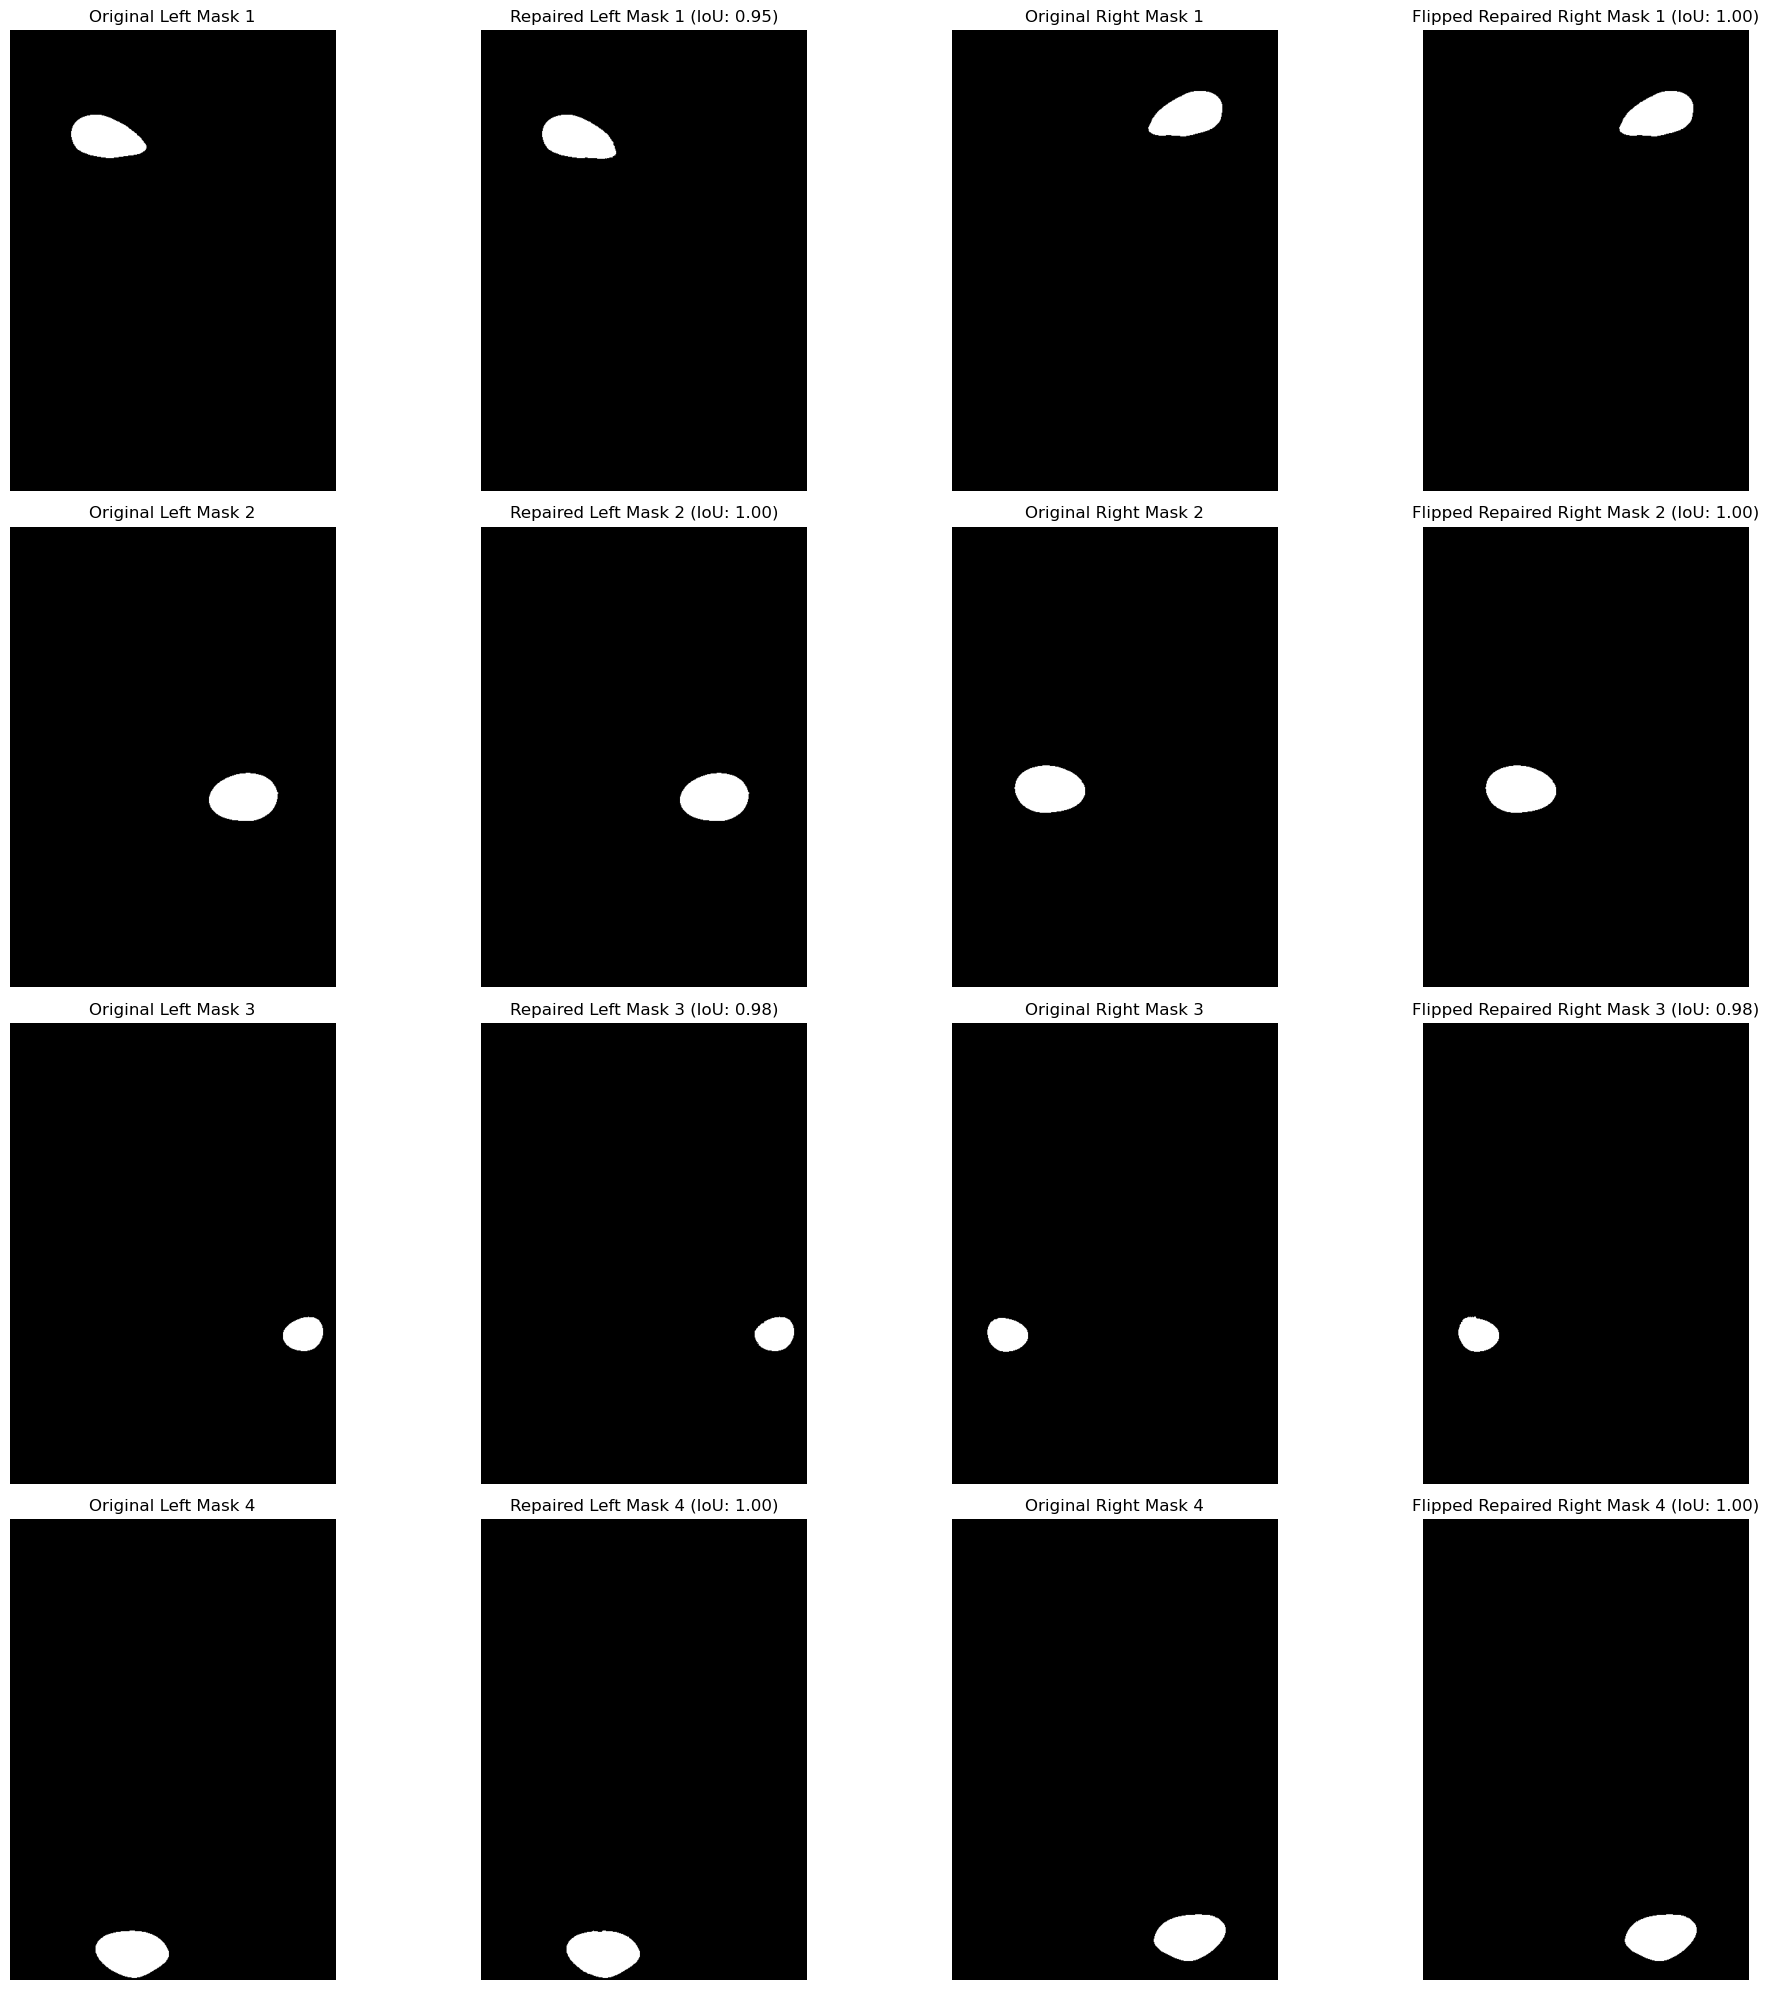

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to convert radii to polygon vertices
def radii_to_polygon(centroid, angles, radii):
    points = []
    for angle, radius in zip(angles, radii):
        x = centroid[0] + radius * np.cos(np.radians(angle))
        y = centroid[1] + radius * np.sin(np.radians(angle))
        points.append((int(x), int(y)))
    return np.array([points], dtype=np.int32)

# Function to draw the adjusted polygon on a mask
def draw_adjusted_polygon_on_mask(mask, polygon):
    """
    Draw the adjusted polygon on the original mask.

    Parameters:
    - mask: np.array, the original mask to draw upon.
    - polygon: np.array, coordinates of the polygon vertices.

    Returns:
    - np.array: The mask with the drawn polygon.
    """
    repair_mask = np.zeros_like(mask)
    cv2.fillPoly(repair_mask, [polygon], 255)
    repaired_mask = cv2.bitwise_or(mask, repair_mask)
    return repaired_mask

# Example of applying the repair process to all masks using the adjusted radii
repaired_left_masks = []
repaired_right_masks = []

for i, (left_mask, right_mask, left_radii, right_radii, left_centroid, right_centroid) in enumerate(zip(left_masks, right_masks_flipped, left_adjusted_radii_list, right_adjusted_radii_list, left_centroids_list, right_centroids_list)):
    # Convert radii back to polygon vertices
    left_polygon = radii_to_polygon(left_centroid, angles, left_radii)
    right_polygon = radii_to_polygon(right_centroid, angles, right_radii)
    
    # Draw the polygons on the masks
    repaired_left_mask = draw_adjusted_polygon_on_mask(left_mask, left_polygon)
    repaired_right_mask = draw_adjusted_polygon_on_mask(right_mask, right_polygon)
    
    repaired_left_masks.append(repaired_left_mask)
    repaired_right_masks.append(repaired_right_mask)

# Load original masks
def load_masks(mask_dir):
    """
    Load masks from a directory.
    
    Parameters:
    - mask_dir: str, path to the directory containing mask files.
    
    Returns:
    - list of np.array: List containing the loaded masks.
    """
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])
    masks = [cv2.imread(os.path.join(mask_dir, file), cv2.IMREAD_GRAYSCALE) for file in mask_files]
    return masks

# Path to the directories containing the original masks
left_mask_dir = 'test_links/original'
right_mask_dir = 'test_rechts/original'

# Load the original masks
original_left_masks = load_masks(left_mask_dir)
original_right_masks = load_masks(right_mask_dir)

# Function to calculate Intersection over Union (IoU)
def calculate_iou(mask1, mask2):
    """
    Calculate the Intersection over Union (IoU) between two binary masks.
    
    Parameters:
    - mask1: np.array, first binary mask.
    - mask2: np.array, second binary mask.
    
    Returns:
    - float: The IoU value.
    """
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

# Flip the right repaired masks and calculate IoU
flipped_right_repaired_masks = [cv2.flip(mask, 1) for mask in repaired_right_masks]
iou_left = [calculate_iou(original, repaired) for original, repaired in zip(original_left_masks, repaired_left_masks)]
iou_right = [calculate_iou(original, flipped) for original, flipped in zip(original_right_masks, flipped_right_repaired_masks)]

# Plot the original and repaired masks along with IoU values
fig, axes = plt.subplots(len(repaired_left_masks), 4, figsize=(20, 5 * len(repaired_left_masks)))

for i in range(len(repaired_left_masks)):
    # Original left mask
    axes[i, 0].imshow(original_left_masks[i], cmap='gray')
    axes[i, 0].set_title(f'Original Left Mask {i + 1}')
    axes[i, 0].axis('off')

    # Repaired left mask
    axes[i, 1].imshow(repaired_left_masks[i], cmap='gray')
    axes[i, 1].set_title(f'Repaired Left Mask {i + 1} (IoU: {iou_left[i]:.2f})')
    axes[i, 1].axis('off')

    # Original right mask
    axes[i, 2].imshow(original_right_masks[i], cmap='gray')
    axes[i, 2].set_title(f'Original Right Mask {i + 1}')
    axes[i, 2].axis('off')

    # Flipped and repaired right mask
    axes[i, 3].imshow(flipped_right_repaired_masks[i], cmap='gray')
    axes[i, 3].set_title(f'Flipped Repaired Right Mask {i + 1} (IoU: {iou_right[i]:.2f})')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()

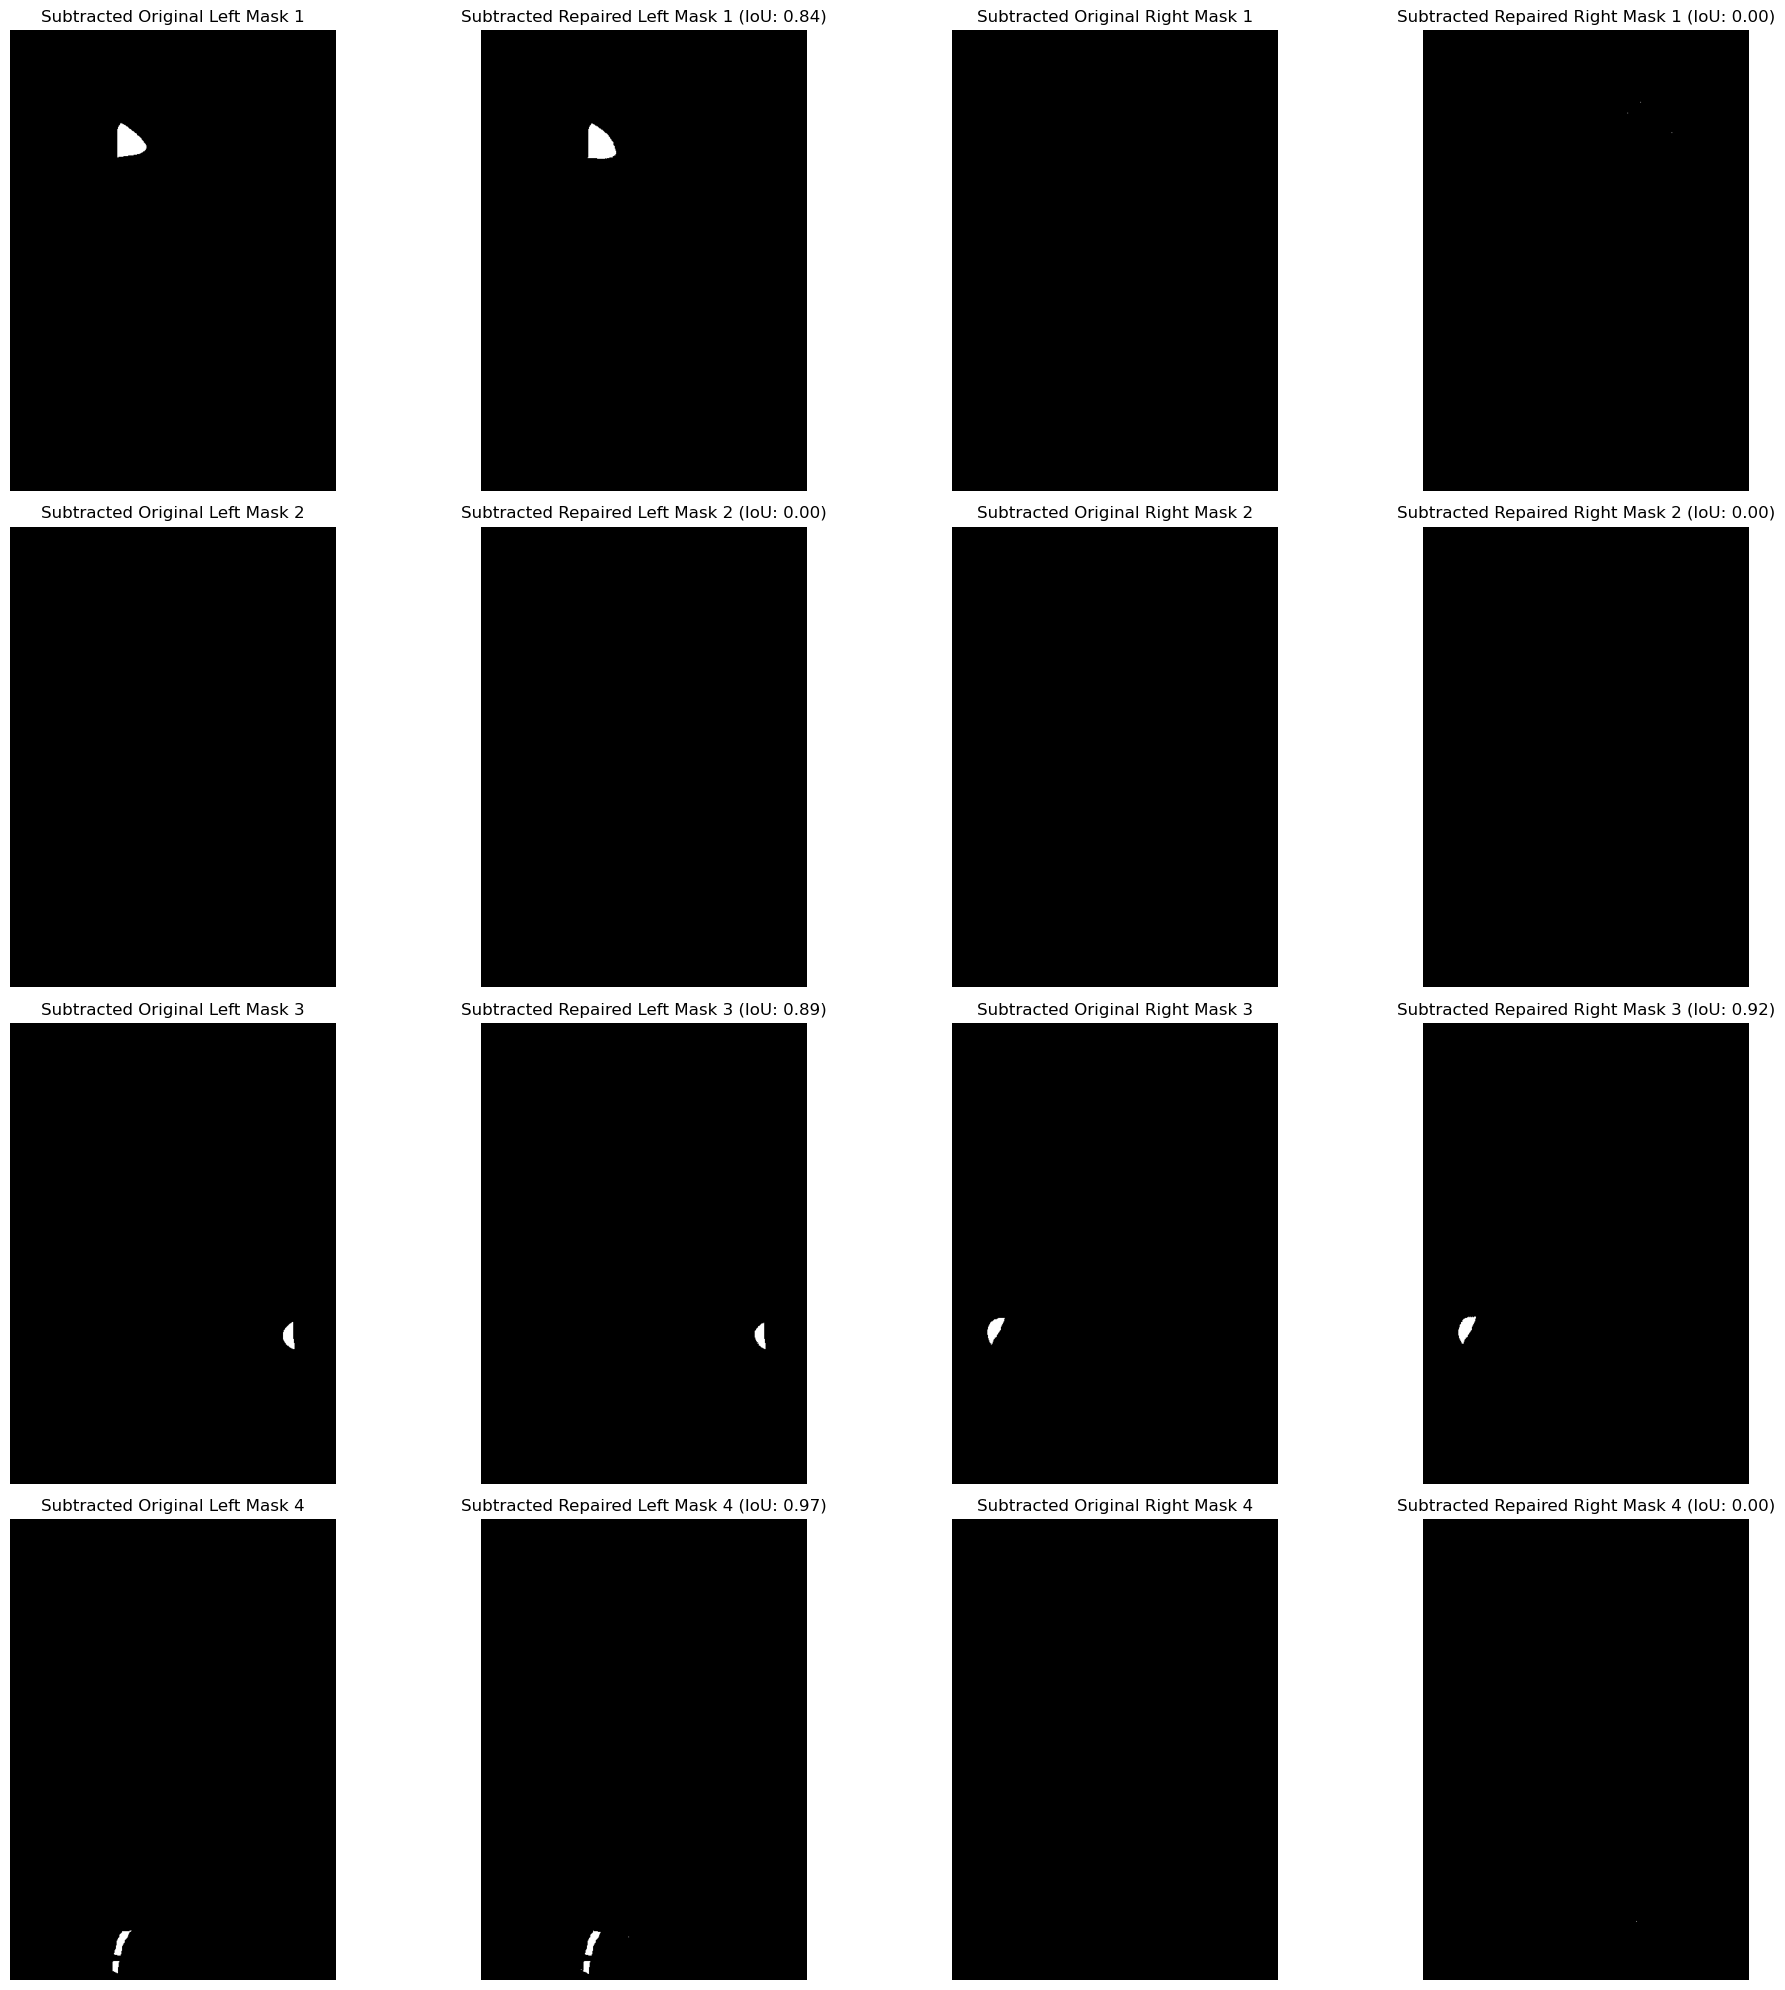

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Subtract masks function
def subtract_masks(mask1, mask2):
    """
    Subtract mask2 from mask1, ensuring that no negative values exist.

    Parameters:
    - mask1: np.array, mask from which to subtract.
    - mask2: np.array, mask to subtract.

    Returns:
    - np.array: The result of the subtraction.
    """
    return cv2.subtract(mask1, mask2)

# Recompute IoU to focus only on the repaired parts
def compute_repair_iou(original, repaired, mask):
    """
    Compute the Intersection over Union (IoU) focusing on the repaired parts by subtracting the mask area.

    Parameters:
    - original: np.array, original mask.
    - repaired: np.array, repaired mask.
    - mask: np.array, mask to subtract from both original and repaired masks.

    Returns:
    - float: The IoU value.
    """
    original_subtracted = subtract_masks(original, mask)
    repaired_subtracted = subtract_masks(repaired, mask)
    intersection = np.logical_and(original_subtracted > 0, repaired_subtracted > 0)
    union = np.logical_or(original_subtracted > 0, repaired_subtracted > 0)
    if np.sum(union) == 0:
        return 0  # Avoid division by zero if there's no area to compare
    return np.sum(intersection) / np.sum(union)

# Apply mask subtraction and compute IoU for each mask
iou_left_repair = [compute_repair_iou(original, repaired, mask) for original, repaired, mask in zip(original_left_masks, repaired_left_masks, left_masks)]
iou_right_repair = [compute_repair_iou(original, repaired, mask) for original, repaired, mask in zip(original_right_masks, flipped_right_repaired_masks, right_masks)]

# Visualization of IoU results for repaired areas
fig, axes = plt.subplots(len(repaired_left_masks), 4, figsize=(20, 5 * len(repaired_left_masks)))

for i in range(len(repaired_left_masks)):
    # Plot the subtracted original left mask
    axes[i, 0].imshow(subtract_masks(original_left_masks[i], left_masks[i]), cmap='gray')
    axes[i, 0].set_title(f'Subtracted Original Left Mask {i + 1}')
    axes[i, 0].axis('off')

    # Plot the subtracted repaired left mask
    axes[i, 1].imshow(subtract_masks(repaired_left_masks[i], left_masks[i]), cmap='gray')
    axes[i, 1].set_title(f'Subtracted Repaired Left Mask {i + 1} (IoU: {iou_left_repair[i]:.2f})')
    axes[i, 1].axis('off')

    # Plot the subtracted original right mask
    axes[i, 2].imshow(subtract_masks(original_right_masks[i], right_masks[i]), cmap='gray')
    axes[i, 2].set_title(f'Subtracted Original Right Mask {i + 1}')
    axes[i, 2].axis('off')

    # Plot the subtracted repaired right mask
    axes[i, 3].imshow(subtract_masks(flipped_right_repaired_masks[i], right_masks[i]), cmap='gray')
    axes[i, 3].set_title(f'Subtracted Repaired Right Mask {i + 1} (IoU: {iou_right_repair[i]:.2f})')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()

